In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load data, Extract features

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki = wiki.sample(frac=0.1, random_state=0) # Using 10% of the data as to reduce compute time
wiki.head()

,URI,name,text
50034,<http://dbpedia.org/resource/Mauno_J%C3%A4rvel...,Mauno J%C3%A4rvel%C3%A4,mauno jrvel born 25 november 1949 in kaustinen...
39362,<http://dbpedia.org/resource/David_W._Jourdan>,David W. Jourdan,david walter jourdan born december 5 1954 is a...
20786,<http://dbpedia.org/resource/Patrick_Roach>,Patrick Roach,patrick roach born march 4 1969 is a canadian ...
26367,<http://dbpedia.org/resource/Louis_Sauer>,Louis Sauer,louis lou sauer aka louis edward sauer born 19...
14855,<http://dbpedia.org/resource/Marty_Keough>,Marty Keough,richard martin keough born april 14 1934 in oa...


To work with text data, we must first convert the documents into numerical features. Let's extract TF-IDF features for each article.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(wiki['text'])
words = vectorizer.get_feature_names()

Since most documents don't contain every word, many of the TF-IDF entries will be 0. Representing the TF-IDF matrix as a `numpy` matrix will require a lot of unnecessary storage to keep track of all those 0. SciPy provides the idea of a "sparse matrix" that only represents the non-zero entries of a matrix to save space. Externally, you treat it just like a numpy `matrix` but it takes up less storage.

In [4]:
tf_idf = csr_matrix(tf_idf)

tf_idf.shape

(5907, 112801)

The above matrix contains a TF-IDF score for each of the 5907 pages in the data set and each of the 112801 unique words.

# Normalize all vectors

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|_2^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y}) & \text{(def of L2 norm)}\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y}) & \text{(FOIL expression)}\\
                              &= \|\mathbf{x}\|_2^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|_2^2 & \text{(def of L2 norm)}\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y}) & \text{($\mathbf{x}$ and $\mathbf{y}$ are length 1)}\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|_2\|\mathbf{y}\|_2}\right) & \text{(Dividing by 1 doesn't change value)}\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.


---
We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [5]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

# Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.


In [6]:
def get_initial_centroids(data, k, seed=None):
    """
    Randomly choose k data points as initial centroids
    """
    if seed is not None:
        np.random.seed(seed)
        
    n = data.shape[0] 
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

### k-means Algorithm
After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid. $$z_i \gets \mathrm{argmin}_j \|\mathbf{\mu}_j - \mathbf{x}_i\|^2$$
2. Revise centroids as the mean of the assigned data points. $$\mathbf{\mu}_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i$$

In pseudocode, we iteratively do the following:
```python
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

## Assigning clusters

How do we implement Step 1 of the main k-means loop above? First we import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [7]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')
print(dist)

[[1.39996239 1.39958932]
 [1.40386156 1.39754968]
 [1.38421176 1.39682604]
 ...
 [1.40562888 1.39024794]
 [1.39673862 1.38306708]
 [1.40872806 1.40250208]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

In [8]:
c = tf_idf[0:3,:]
distances = pairwise_distances(tf_idf, c, metric='euclidean')
dist = distances[430,1]

In [12]:
centroids = tf_idf[0:3,:]
d = pairwise_distances(tf_idf, centroids, metric='euclidean')
cluster_assignment = np.argmin(d, axis=1)

In [14]:
def assign_clusters(data, centroids):
    """
    Parameters:  
      - data      - is an np.array of float values of length N.  
      - centroids - is an np.array of float values of length k.

    Returns  
      -  A np.array of length N where the ith index represents which centroid 
         data[i] was assigned to. The assignments range between the values 0, ..., k-1.
    """
    distances = pairwise_distances(data, centroids, metric='euclidean')
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments

## Revising clusters

Let's turn to Step 2 of the k-means algorithm, where we compute the new centroids given the cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```python
data[cluster_assignment==0,:]
```

In [24]:
def revise_centroids(data, k, cluster_assignment):
    """
    Parameters:  
      - data               - is an np.array of float values of length N.
      - k                  - number of centroids
      - cluster_assignment - np.array of length N where the ith index represents which 
                             centroid data[i] was assigned to. The assignments range between the values 0, ..., k-1.

    Returns  
      -  A np.array of length k for the new centroids.
    """
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment == i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
        
    new_centroids = np.array(new_centroids)
    return new_centroids

### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=0}^{k-1} \sum_{i=1:z_i = j}^n \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [26]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    """
    Computes the heterogeneity metric of the data using the given centroids and cluster assignments.
    """
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i,:]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data point
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [27]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [28]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    """
    This function runs k-means on given data and initial set of centroids.
    
    Parameters:  
      - data                 - is an np.array of float values of length N.
      - k                    - number of centroids
      - initial_centroids    - is an np.array of float values of length k.
      - maxiter              - maximum number of iterations to run the algorithm
      - record_heterogeneity - if provided an empty list, it will compute the heterogeneity 
                               at each iteration and append it to the list. 
                               Defaults to None and won't record heterogeneity.
      - verbose              - set to True to display progress. Defaults to False and won't 
                               display progress.

    Returns  
      - centroids - A np.array of length k for the centroids upon termination of the algorithm.
      - cluster_assignment - A np.array of length N where the ith index represents which 
                             centroid data[i] was assigned to. The assignments range between the 
                             values 0, ..., k-1 upon termination of the algorithm.
    """
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):  
        # Print itereation number
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, initial_centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment == cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment - cluster_assignment))
            if verbose:
                print(f'    {num_changed:5d} elements changed their cluster assignment.')  
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [29]:
def plot_heterogeneity(heterogeneity, k):
    """
    Plots how the heterogeneity changes as the number of iterations increases.
    """
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title(f'Heterogeneity of clustering over time, K={k}')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1


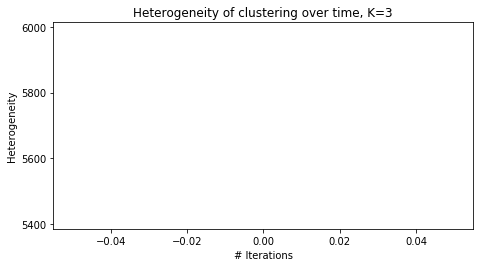

In [30]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)


In [31]:
np.bincount(cluster_assignment)

array([3916,  831, 1160], dtype=int64)

# Beware of Local Minima

One weakness of k-means is that it tends to get stuck in a local minimum based on its starting position. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.


In [32]:
%%time

k = 10
heterogeneity = {}
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print(f'seed={seed:06d}, heterogeneity={heterogeneity[seed]:.5f}')
    
    sys.stdout.flush()

seed=000000, heterogeneity=5637.35477
seed=020000, heterogeneity=5628.17552
seed=040000, heterogeneity=5656.61492
seed=060000, heterogeneity=5626.79996
seed=080000, heterogeneity=5623.32338
seed=100000, heterogeneity=5615.73065
seed=120000, heterogeneity=5641.14122
Wall time: 1.98 s


Notice the variation in heterogeneity for different initializations. This indicates that k-means runs may have not converged or they got stuck at a local minimum.

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime, but is a bit slower to start since it needs to do more computation to place centroids.

In [33]:
def smart_initialize(data, k, seed=None):
    """
    Use k-means++ to initialize a good set of centroids
    """
    if seed is not None:
        np.random.seed(seed)
        
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [34]:
%%time

k = 10
heterogeneity_smart = {}
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print(f'seed={seed:06d}, heterogeneity={heterogeneity_smart[seed]:.5f}')

    sys.stdout.flush()

seed=000000, heterogeneity=5657.01878
seed=020000, heterogeneity=5638.05710
seed=040000, heterogeneity=5630.05621
seed=060000, heterogeneity=5648.38517
seed=080000, heterogeneity=5628.74359
seed=100000, heterogeneity=5633.01894
seed=120000, heterogeneity=5635.11785
Wall time: 3.57 s


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

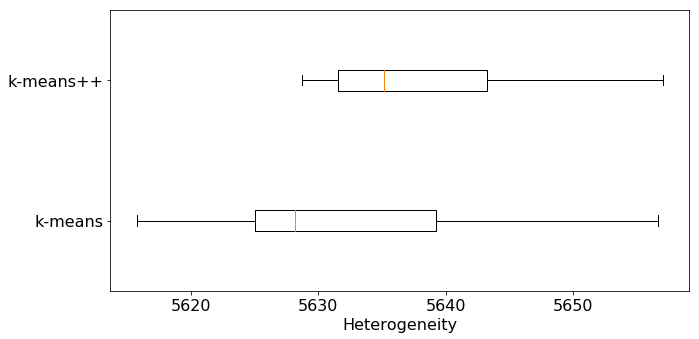

In [35]:
plt.figure(figsize=(10,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.xlabel('Heterogeneity')
plt.tight_layout()

A few things to notice from the box plot:
* Random initialization results in a worse clustering than k-means++ on average.
* The best result of k-means++ is better than the best result of random initialization.

In [38]:
def kmeans_multiple_runs(data, k, maxiter, seeds, verbose=False):
    """
    Runs kmeans multiple times 
    
    Parameters:  
      - data    - is an np.array of float values of length N.
      - k       - number of centroids
      - maxiter - maximum number of iterations to run the algorithm
      - seeds   - Either number of seeds to try (generated randomly) or a list of seed values
      - verbose - set to True to display progress. Defaults to False and won't display progress.
    
    Returns  
      - final_centroids          - A np.array of length k for the centroids upon 
                                   termination of the algorithm.
      - final_cluster_assignment - A np.array of length N where the ith index represents which 
                                   centroid data[i] was assigned to. The assignments range between 
                                   the values 0, ..., k-1 upon termination of the algorithm.
    """    
    min_heterogeneity_achieved = float('inf')
    final_centroids = None
    final_cluster_assignment = None
    if type(seeds) == int:
        seeds = np.random.randint(low=0, high=10000, size=seeds)
    
    num_runs = len(seeds)
    
    for seed in seeds:
        
        # Use k-means++ initialization with the provided seed: Fill in the blank
        # Set record_heterogeneity=None because we will compute that once at the end.
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means: Fill in the blank 
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # Fill in the blank on the right
        seed_heterogeneity = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print(f'seed={seed:06d}, heterogeneity={seed_heterogeneity:.5f}')
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if seed_heterogeneity < min_heterogeneity_achieved:
            min_heterogeneity_achieved = seed_heterogeneity
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.



Running k = 2
seed=020000, heterogeneity=5707.49794
seed=040000, heterogeneity=5704.51207
seed=080000, heterogeneity=5685.53624
Running k = 10
seed=020000, heterogeneity=5638.05710
seed=040000, heterogeneity=5630.05621
seed=080000, heterogeneity=5628.74359
Running k = 25
seed=020000, heterogeneity=5567.14966
seed=040000, heterogeneity=5559.25484
seed=080000, heterogeneity=5568.99667
Running k = 50
seed=020000, heterogeneity=5496.77086
seed=040000, heterogeneity=5514.12112
seed=080000, heterogeneity=5508.93097
Running k = 100
seed=020000, heterogeneity=5399.81193
seed=040000, heterogeneity=5416.88642
seed=080000, heterogeneity=5399.67106
Wall time: 54.6 s


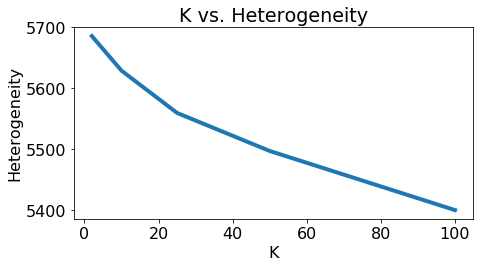

In [39]:
%%time

def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    """
    Given list of k-values and their heterogeneities, will make a plot
    showing how heterogeneity varies with k.
    """
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

all_centroids = {}
all_cluster_assignment = {}
heterogeneity_values = []
seeds = [20000, 40000, 80000]
k_list = [2, 10, 25, 50, 100]

for k in k_list:
    print(f'Running k = {k}')
    heterogeneity = []
    all_centroids[k], all_cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
                                                                       seeds=seeds, verbose=True)
    score = compute_heterogeneity(tf_idf, k, all_centroids[k], all_cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [40]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, words, 
                                display_docs=5):
    """
    Given a set of clustered documents, prints information about the centroids including
       - The title and starting sentence of the closest 5 points to each centroid
       - The five words that are contained in the clusters documents with the highest TF-IDF.
    
    Parameters:  
      - wiki: original dataframe
      - tf_idf: data matrix containing TF-IDF vectors for each document
      - centroids: A np.array of length k that contains the centroids for the clustering
      - cluster_assignments: A np.array of length N that has the cluster assignments for each row
      - k: What value of k is used
      - words: List of words in the corpus (should match tf_idf)
      - display_odcs: How many documents to show for each cluster (default 5)
    """
    print('=' * 90)

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print(f'Cluster {c}  ({(cluster_assignment == c).sum()} docs)'),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print(f'{words[idx[i]]}:{centroids[c,idx[i]]:.3f}', end=' '),
        print()
        
        if display_docs > 0:
            print()
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For the nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(display_docs):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print(f'* {wiki.iloc[nearest_neighbors[i]]["name"]:50s} {distances[nearest_neighbors[i]]:.5f}')
                print(f'  {text[:90]}')
                if len(text) > 90:
                    print(f'  {text[90:180]}')
                print()
        print('=' * 90)

Let us first look at the 2 cluster case (K=2).

In [41]:
k = 2
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k, words)

Cluster 0  (2576 docs)
she:0.071 her:0.051 for:0.038 was:0.034 as:0.033 

* Natashia Williams                                  0.93245
  natashia williamsblach born august 2 1978 is an american actress and former wonderbra camp
  aign model who is perhaps best known for her role as shane

* Bhama Srinivasan                                   0.94091
  bhama srinivasan april 22 1935 is a mathematician known for her work in the representation
   theory of finite groups her contributions were honored with the

* Bette McLaurin                                     0.94135
  bette mclaurin born c1929 is an africanamerican singer best known for her jazzinfluenced b
  allad and rb performances in the 1950s two of her recordings i

* Delores Brumfield                                  0.94150
  delores brumfield white born may 26 1932 is a former utility infielderoutfielder who playe
  d from 1947 through 1953 in the allamerican girls professional baseball league

* Anne Harris (musician)        

Both clusters have mixed content, although clearly cluster 0 are all women and cluster 1 are all men:

It would be better if we sub-divided into more categories. So let us use more clusters. How about `K=10`?

In [42]:
k = 10
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k, words)

Cluster 0  (1240 docs)
she:0.113 her:0.090 for:0.040 was:0.036 as:0.032 

* Bhama Srinivasan                                   0.91625
  bhama srinivasan april 22 1935 is a mathematician known for her work in the representation
   theory of finite groups her contributions were honored with the

* Delores Brumfield                                  0.91828
  delores brumfield white born may 26 1932 is a former utility infielderoutfielder who playe
  d from 1947 through 1953 in the allamerican girls professional baseball league

* Bette McLaurin                                     0.92113
  bette mclaurin born c1929 is an africanamerican singer best known for her jazzinfluenced b
  allad and rb performances in the 1950s two of her recordings i

* Kate Walsh (singer)                                0.92510
  kate walsh born february 20 1983 is an english singer from burnhamoncrouch essex a graduat
  e of the brighton institute of modern music her first album

* Gila Golan                   

We no longer have the clear split between men and women. Cluters 0 and 2 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: notable women
* Cluster 1: baseball players
* Cluster 2: researchers, professors
* Cluster 3: football(soccer)
* Cluster 4: musicians, singers, song writers
* Cluster 5: golfers
* Cluster 6: painters, scultpers, artists
* Cluster 7: orchestral musicians, conductors
* Cluster 8: politicians, political personel
* Cluster 9: film directors|

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of film directors. Increasing the number of clusters may split larger clusters. Another way to look at the size of cluster is to count the number of articles in each cluster.

In [43]:
np.bincount(all_cluster_assignment[10])

array([1240,  812,  157,  868,  886,  218,  194,  115, 1119,  298],
      dtype=int64)

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.

In [44]:
k = 25
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k,
                            words, display_docs=0) # turn off text for brevity

Cluster 0  (297 docs)
band:0.078 album:0.074 he:0.053 with:0.045 his:0.044 
Cluster 1  (169 docs)
he:0.084 bbc:0.052 as:0.047 his:0.043 for:0.041 
Cluster 2  (125 docs)
art:0.093 she:0.080 museum:0.046 her:0.037 at:0.037 
Cluster 3  (112 docs)
he:0.075 was:0.043 medical:0.038 as:0.037 chief:0.037 
Cluster 4  (55 docs)
language:0.067 he:0.048 linguistics:0.043 university:0.040 his:0.037 
Cluster 5  (396 docs)
she:0.144 her:0.078 was:0.047 at:0.041 for:0.032 
Cluster 6  (188 docs)
he:0.068 as:0.044 law:0.043 for:0.042 on:0.036 
Cluster 7  (33 docs)
he:0.077 league:0.058 france:0.057 for:0.056 club:0.055 
Cluster 8  (148 docs)
he:0.057 his:0.053 music:0.047 as:0.039 dj:0.036 
Cluster 9  (951 docs)
he:0.078 university:0.049 at:0.038 was:0.038 research:0.036 
Cluster 10  (265 docs)
music:0.100 he:0.060 for:0.044 his:0.042 with:0.041 
Cluster 11  (183 docs)
he:0.097 club:0.061 his:0.046 for:0.046 was:0.043 
Cluster 12  (86 docs)
opera:0.185 she:0.084 her:0.044 with:0.040 at:0.038 
Cluster 13

Looking at the representative examples and top words, we classify each cluster as follows. Notice the bolded items, which indicate the appearance of a new theme.
* Cluster 0: **British labor party**
* Cluster 1: **Bishops**
* Cluster 2: **danish CEOs**
* Cluster 3: baseball
* Cluster 4: politicials
* Cluster 5: **psychology researchers**
* Cluster 6: **medical researchers**
* Cluster 7: **republican politicians**
* Cluster 8: football(soccer)
* Cluster 9: **prime ministers**
* Cluster 10: golfers
* Cluster 11: coaches
* Cluster 12: **lawers**
* Cluster 13: researchers, professors
* Cluster 14: writers
* Cluster 15: artists, museaum workers
* Cluster 16: film directors
* Cluster 17: musicians
* Cluster 18: **airforce commanders**
* Cluster 19: orchestral musicians
* Cluster 20: *unclear*
* Cluster 21: *unclear*
* Cluster 22: *unclear*
* Cluster 23: politicians
* Cluster 24: **hockey players**

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [50]:
k=100
visualize_document_clusters(wiki, tf_idf, all_centroids[k], all_cluster_assignment[k], k,
                            words, display_docs=0)

Cluster 0  (236 docs)
she:0.099 her:0.091 music:0.045 for:0.044 with:0.036 
Cluster 1  (210 docs)
coach:0.110 he:0.082 team:0.050 football:0.047 was:0.047 
Cluster 2  (14 docs)
director:0.065 he:0.063 mr:0.058 hooker:0.050 jindal:0.050 
Cluster 3  (140 docs)
football:0.082 he:0.078 australian:0.077 afl:0.060 his:0.056 
Cluster 4  (188 docs)
music:0.115 he:0.086 his:0.053 with:0.046 has:0.038 
Cluster 5  (90 docs)
championships:0.084 world:0.077 he:0.072 metres:0.056 at:0.053 
Cluster 6  (9 docs)
yoga:0.236 iskcon:0.089 he:0.065 new:0.063 swami:0.062 
Cluster 7  (47 docs)
opera:0.227 she:0.074 at:0.042 with:0.041 la:0.040 
Cluster 8  (110 docs)
he:0.087 chairman:0.069 board:0.058 was:0.051 member:0.038 
Cluster 9  (98 docs)
she:0.117 series:0.075 miss:0.073 her:0.065 role:0.059 
Cluster 10  (48 docs)
law:0.268 he:0.073 legal:0.062 school:0.054 court:0.052 
Cluster 11  (64 docs)
japanese:0.070 he:0.060 his:0.041 war:0.036 for:0.035 
Cluster 12  (105 docs)
law:0.072 he:0.071 federal:0.046

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Scotland, Brazil, LGBT, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**
